### Data Source
In this exercise we shall be using [The National Health and Nutrition Examination Surveys](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/overview.aspx?BeginYear=2015) (NHANES) dataset specifically the [nhanes 2015-2016](https://raw.githubusercontent.com/UMstatspy/UMStatsPy/master/NHANES/merged/nhanes_2015_2016.csv). Alternatively, the dataset can also be found at [nhanes 2015-2016](https://github.com/rashida048/Datasets/blob/master/nhanes_2015_2016.csv).

**Description of the variables can be found at [Data Processing and Editing](https://wwwn.cdc.gov/nchs/nhanes/2015-2016/DEMO_I.htm)**.

* **RIDAGEYR**: Age in years, at the time of the screening interview
* **RIDRETH1**: Race/Hispanic origin (1 = Mexican American, 3 = Non-Hispanic White, 4 = Non-Hispanic Black)
* **RIAGENDR**: Gender (1 = Male, 2 = Female)
* **SMQ020**: Smoker (1 = YES, 2 = NO)
* **BMXBMI**: Body Mass Index
* **BPXSY**(1 and 2): = Systolic Blood Pressure

#### Some Python Packages we shall be using

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.oneway import effectsize_oneway
import scikit_posthocs as sp
import os
from collections import Counter
%matplotlib inline
os.chdir('./resources/')

### Research Question 1
Was the **mean systolic blood pressure** for non-Hispanic **African-American age 18+** in U.S in 2015-2016 equal to **128 mmHg** or was the **population mean different from 128**?

#### Some data from the Research Question
* Population: Non-Hispanic **African-American above 18 years** in U.S in 2015-2016
* Null Hypothesis H0: The **mean Systolic Blood Pressure** for non-Hispanic **African-American above 18 years** in U.S in 2015-2016 is equal to **128 mmHg**($H0: \mu = 128$) mmHg. 
* Alternative Hypothesis H1: The **mean Systolic Blood Pressure** for non-Hispanic **African-American above 18 years** in U.S in 2015-2016 is not equal to **128 mmHg**($H0: \mu \ne 128$) mmHg. 

Based on the research question we are interested in a descriptive measure of central tendency - the mean of a single group. 
The appropriate inferential procedure is the **One Sample z-test for Means**. And since we are not ineterest in whether the mean is greater than or less than the null, this is **non-directional** or **two-tailed test**.

We shall consider a **Type I Error or signicance level of 5% (alpha = 0.05)**. This is the **risk of rejecting the null hypothesis when it is true!**
### Let have a look at the data

In [3]:
df = pd.read_csv('nhanes_2015_2016.csv')
print(f'Size of dataset = {df.shape}')
df.head()

Size of dataset = (5735, 28)


,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


#### NOTE
NHANES researchers wanted to make sure that measures of blood pressure are realiable across subgroups. Therefore each NHANES respondent had two measures collected (**BPXSY1** and **BPXSY2**). We will use **BPXSY1** in this analysis. 

In [4]:
df1 = df.copy()
df_bp1 = df1[(df1['RIDAGEYR'] >= 18) & (df1['RIDRETH1'] == 4)]['BPXSY1'].dropna()

In [5]:
print(df_bp1.describe())

count    1135.000000
mean      128.251982
std        19.958244
min        84.000000
25%       114.000000
50%       126.000000
75%       138.000000
max       236.000000
Name: BPXSY1, dtype: float64


In [6]:
mean = df_bp1.describe()['mean']
n = df_bp1.describe()['count']
print(f'sample mean(SBP) = {round(mean, 2)}')
print(f'Number of respondents = {n}')

sample mean(SBP) = 128.25
Number of respondents = 1135.0


Our sample mean is **`128.25`** while our null is **`128`**. The difference is not much but our test would tell us whether this small difference is significant or not for the **population** of **non-Hispanic African-American above 18 years in U.S in 2015-2016**.

But first we need to check the assumptions required for the **z-test**. 
* The samples are expected to be independent and identically distributed (iid). This means that the samples should be independent and randomly selected from a polulation with identical distribution. We would assuption that the NHANES data meets this criterion.
* The sample is expected to be normally distributed. Let's check this using plots.

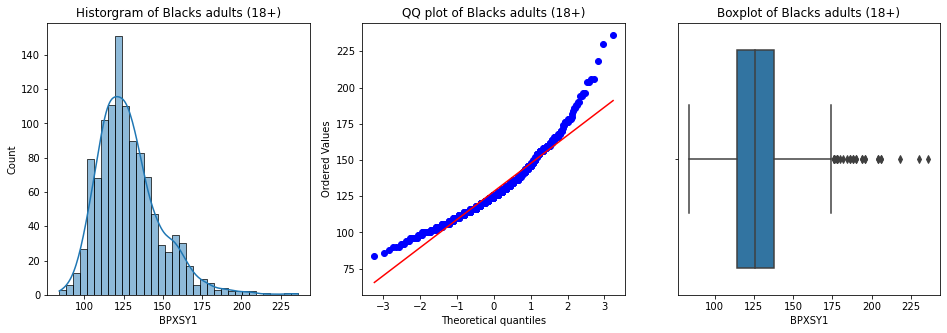

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (16, 5), sharex = False)
sns.histplot(df_bp1, kde = True, ax = axes[0])
axes[0].title.set_text('Historgram of Blacks adults (18+)')
stats.probplot(df_bp1, dist = 'norm', plot = axes[1])              
axes[1].title.set_text('QQ plot of Blacks adults (18+)')
sns.boxplot(x = df_bp1, ax = axes[2])
axes[2].title.set_text('Boxplot of Blacks adults (18+)')

From the looks of things we can conclude, with sufficient data and based on the **Central Limit Theorem (CLT)**, that the sample is coming from a population that is normally distributed and therefore go ahead with our analysis. There are many approaches to this test but we shall use **statsmodels's `stats.ztest` methode to compute the test statistic (z-value) and p-value**. 

For a **two-tailed** test the **signicance level of 5% or 0.05** is divided by **2** - **0.025** for each tail.

In [8]:
test_stat, pvalue = sm.stats.ztest(df_bp1, value = 128, alternative = 'two-sided')   

print(f'test statistic (z-value) = {round(test_stat, 3)}')
print(f'pvalue = {round(pvalue, 3)}\n')

alpha = 0.05 / 2

H0 = '"The mean Systolic Blood Pressure for non-Hispanic African-American above 18 years in U.S in 2015-2016 \
is equal to 128 mmHg"'

H1 = '"The mean Systolic Blood Pressure for non-Hispanic African-American above 18 years in U.S in 2015-2016 \
is not equal to 128 mmHg"'

if pvalue <= alpha:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')
    print('The results from the observed sample is due to random chance!')

test statistic (z-value) = 0.425
pvalue = 0.671

Not significant outcome! Fail to reject the null hypothesis which states that:
"The mean Systolic Blood Pressure for non-Hispanic African-American above 18 years in U.S in 2015-2016 is equal to 128 mmHg"
The results from the observed sample is due to random chance!


The conclusion here is that with a null mean of 128 mmHg, observing a **sample mean Systolic Blood Pressure of 128.252 mmHg** or more extreme among **African-American above 18 years in U.S in 2015-2016** is **quite likely**. We therefore **do not have enough eveidence (from observed sample) to reject the Null Hypothesis**.

### Effect Size
**Effect size** is a measure of **how different two groups are from one another**. For example it’s a measure of the magnitude of the treatment given to one group that makes it significantly different from the other group. **Effect Size** would tell whether **statistically significant difference is also meaningful or not**. The **Effect Size** is computed using the **Cohen’s d** formula. For a **one-sample Z-test** it is given by:

$d = \frac{\bar{x} - \mu}{\sigma}$   where

* $\bar{x}$ = sample mean
* $\sigma$ = the standard deviation for the population
* $\mu$ = population mean

In [9]:
def cohen_d(mean, mu, std):
    return (mean - mu) / std

In [10]:
mu = 128
mean = df_bp1.describe()['mean']
std = df_bp1.describe()['std']

d = cohen_d(mean, mu, std)
print(f'Effect Size(d) = {round(d, 2)}')

Effect Size(d) = 0.01


An **Effect Size = 0.1** is considered **small** meaning that the difference between the **sample mean** and the **population mean** is too small or not so **meaningful**!

### Confidence Interval
The **Confidence Interval** is the range of plausible values for a population parameter. It's computed as:

**`Confidence_Interval = Best_Estimate` $\pm$ `Margin_of_Error`**

$CI = \bar{x} \pm z_{crit} \frac{s}{\sqrt{n}}$

We can use **statsmodels's** **`stats.DescrStatsW(data).zconfint_mean()`** to compute the **Confidence Interval** for the population mean of a single variable.

In [15]:
ci = sm.stats.DescrStatsW(df_bp1).zconfint_mean(alpha = 0.05, alternative = 'two-sided')
print(f'Confidence Interval = ({ci[0]: .2f}, {ci[1]: .2f})')

Confidence Interval = ( 127.09,  129.41)


#### Interpretation of the results
With **95%** confidence, the **mean Systolic Blood Pressure among African-American above 18 years in U.S in 2015-2016** is *estimated* to be between **127.09 mmHg** and **129.41 mmHg**. The center of this interval is our **best estimate = 128.25 mmHg** of the population parameter.

This means, if this procedure were repeated over and over, each time computing the **95%** confidence interval estimate, we would expect **95% of those resulting `intervals` to contain the population mean Systolic Blood Pressure**.

### Research Question 2
Considering non-Hispanic **African-American age 18+** in U.S in 2015-2016, did two measures of systolic blood pressure (SBP) differ significantly?

These measures are considered **paired** because they are different measurements (data) of the same variable taken from the same object or group.

#### Some data from the Research Question
* Population: Non-Hispanic **African-American above 18 years** in U.S in 2015-2016
* Null Hypothesis H0: There is no **difference in mean Systolic Blood Pressure** for non-Hispanic **African-American above 18 years** in U.S in 2015-2016 between the two measurements ($H0: \mu_1 = \mu_2$) mmHg. 
* Alternative Hypothesis H1: There is a significant difference in **mean Systolic Blood Pressure** for non-Hispanic **African-American above 18 years** in U.S in 2015-2016 between the two measurements ($H0: \mu_1 \ne \mu_2$) mmHg. 

Based on the research question we are interested in a descriptive measure of central tendency - the **mean difference in Systolic Blood Pressure** between two measure. 
The appropriate inferential procedure is the **Two Sample paired t-test for Means**. And since we are not ineterest in whether the **mean difference** is greater than or less than a particular value, this is **non-directional** or **two-tailed test**.

We shall consider a **Type I Error or signicance level of 5% (alpha = 0.05)**. This is the **risk of rejecting the null hypothesis when it is true!**.

### Let get both measure and make sure both have the same lengths

In [16]:
df_bp = df1[(df1['RIDAGEYR'] >= 18) & (df1['RIDRETH1'] == 4)][['BPXSY1', 'BPXSY2']].dropna()

In [17]:
df_bp1 = df_bp['BPXSY1']
df_bp2 = df_bp['BPXSY2']

In [18]:
print(df_bp1.describe())

count    1128.000000
mean      128.280142
std        20.001231
min        84.000000
25%       114.000000
50%       126.000000
75%       138.000000
max       236.000000
Name: BPXSY1, dtype: float64


In [19]:
print(df_bp2.describe())

count    1128.000000
mean      127.781915
std        19.657366
min        86.000000
25%       114.000000
50%       124.000000
75%       138.000000
max       238.000000
Name: BPXSY2, dtype: float64


#### Plot both samples and investigate assumptions

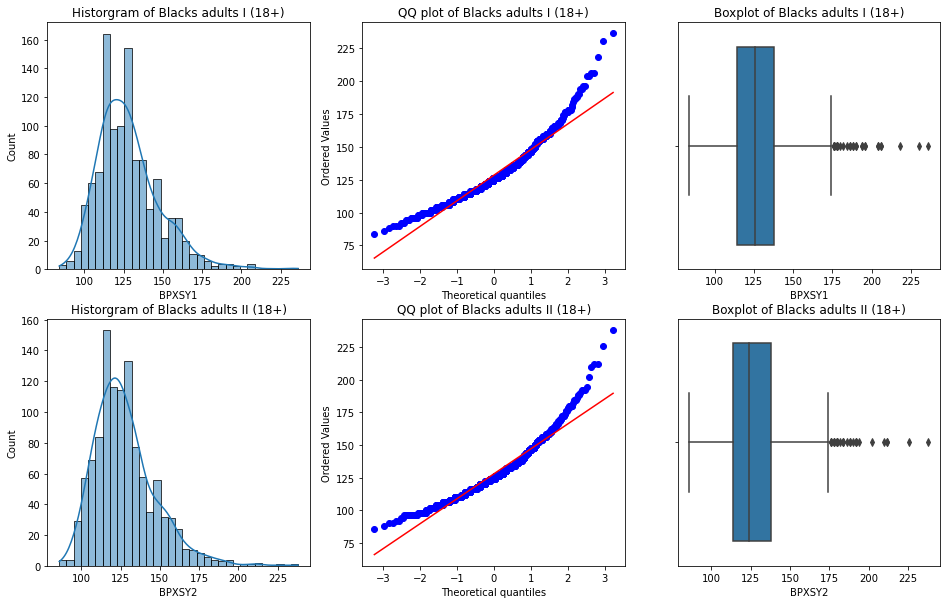

In [20]:
fig, axes = plt.subplots(2, 3, figsize = (16, 10), sharex = False)
sns.histplot(df_bp1, kde = True, ax = axes[0,0])
axes[0,0].title.set_text('Historgram of Blacks adults I (18+)')
stats.probplot(df_bp1, dist = 'norm', plot = axes[0,1])              
axes[0,1].title.set_text('QQ plot of Blacks adults I (18+)')
sns.boxplot(x = df_bp1, ax = axes[0,2])
axes[0,2].title.set_text('Boxplot of Blacks adults I (18+)')

sns.histplot(df_bp2, kde = True, ax = axes[1,0])
axes[1,0].title.set_text('Historgram of Blacks adults II (18+)')
stats.probplot(df_bp2, dist = 'norm', plot = axes[1,1])              
axes[1,1].title.set_text('QQ plot of Blacks adults II (18+)')
sns.boxplot(x = df_bp2, ax = axes[1,2])
axes[1,2].title.set_text('Boxplot of Blacks adults II (18+)')

plt.show()

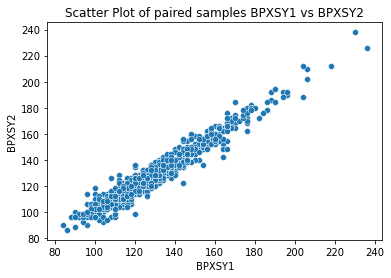

In [21]:
sns.scatterplot(x = df_bp1, y = df_bp2)
plt.title('Scatter Plot of paired samples BPXSY1 vs BPXSY2')
plt.show()

In [22]:
print(f'Mean difference in SBP = {round(np.mean(np.array(df_bp1) - np.array(df_bp2)), 3)}')

Mean difference in SBP = 0.498


**For paired t-test if the degree of freedom is greater than 30 $t_{crit} = Z_{crit}$ at the corresponding confidence level.**

In [23]:
H0 = '"There is no difference in Systolic Blood Pressure for non-Hispanic African-American above 18 years \
in U.S in 2015-2016 between the two measurements."'

H1 = '"There is significant difference in Systolic Blood Pressure for non-Hispanic African-American \
above 18 years in U.S in 2015-2016 between the two measurements."'

test_stat, pvalue = stats.ttest_rel(df_bp1, df_bp2, alternative = 'two-sided')
print(f'test statistic (z-value) = {round(test_stat, 3)}')
print(f'pvalue = {round(pvalue, 3)}\n')

alpha = 0.05 / 2
z_crit = 1.96
if abs(test_stat) >= z_crit:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')
    print('The results from the observed sample is due to random chance!')

test statistic (z-value) = 3.529
pvalue = 0.0

Significant outcome! Reject the null hypothesis which states that:
"There is no difference in Systolic Blood Pressure for non-Hispanic African-American above 18 years in U.S in 2015-2016 between the two measurements."



#### Effect Size using `pooled variance`
The **pooled standard deviation is sort of an average of the standard deviation from Group 1 and the standard deviation from Group 2**.

$es = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}$    where

* $\bar{x_1}$ = is the mean for Group 1
* $\bar{x_2}$ = is the mean for Group 2
* $\sigma_1^2$ = is the variance for Group 1
* $\sigma_2^2$ = is the variance for Group 2

In [24]:
def effectSize(m1, m2, std1, std2):
    return (m1 - m2) / np.sqrt((std1 **2 + std2 ** 2) / 2)

In [25]:
m1 = df_bp1.describe()['mean']
std1 = df_bp1.describe()['std']
m2 = df_bp2.describe()['mean']
std2 = df_bp2.describe()['std']

d = effectSize(m1, m2, std1, std2)
print(f'Effect Size(d) = {round(d, 2)}')

Effect Size(d) = 0.03


The **Effect Size = 0.03** is considered very **small** and indicates that both distributions (**BPXSY1** and **BPXSY2**) almost overlap on each other with little or no variance. Although the inferential analysis seems to suggest the difference of **0.498** is statistically significant, it's not **meaningful**!

#### Let's compute the Pearson's correlation coefficient between both measures

In [26]:
corr_coef, _ = stats.pearsonr(df_bp1, df_bp2)
print(f'Correlation Coefficient = {round(corr_coef, 2)}')

Correlation Coefficient = 0.97


The **correlation coefficient = 0.97** is very high and agrees with the **scatter plot** above suggesting that both measures of **Systolic Blood Pressure (BPXSY1 and BPXSY2)** do not differ significantly. We may therefore **fail to reject the null hypothesis** (depending on the application) due to lack of sufficient evidence against it!

### Research Question 3 
Did **33%** of non-Hispanic **African-Americans age 18+** in the U.S in 2015-2016 have Systolic Blood Pressure greater than 130 mmHg, or was the **population proportions different than one-third?**


* **Population**: **African-Americans (ages 18+)** in the U.S in 2015-2016
* Parameter of Interest: **Population Proportion (p)** of **African-Americans age 18+** in the U.S in 2015-2016 with Systolic Blood Pressure greater than 130 mmHg.

#### State the null (H0) and alternative (H1) hypothesis
* Null Hypothesis: **33%** of non-Hispanic **African-Americans age 18+** in the U.S in 2015-2016 have Systolic Blood Pressure greater than 130 mmHg (H0: p = 0.33).
* Alternative Hypothesis: The proportion of non-Hispanic **African-Americans age 18+** in the U.S in 2015-2016 with Systolic Blood Pressure greater than 130 mmHg is different from **33%** (H0: p $\ne$ 0.33).

#### Set significant level
For a **95%** confidence level the significance level is alpha is **5%** ($\alpha = 0.05$).

### Testing a One Population Proportion

$TestStatistic = \frac{BestEstimate - HypothesizedEstimate}{StandardErrorOfEstimate} = \frac{\bar{p} - p_0}{SE}$

$SE(\bar{p}) = \sqrt{\frac{p.(1 - p)}{n}} => SE(\bar{p}) = \sqrt{\frac{p_0.(1 - p_0)}{n}}$  since we don't know the population **p** yet we can approximate it using $p_0$.

#### Assumptions
* **African-Americans (ages 18+)** were sampled randomly 
* The sample size is large enough for us to assume that the distribution of our sample is **normal** (`n x p0 > 10`) and `n x (1 - p0) > 10`).

#### Get sample data to challenge the Null

In [27]:
df = pd.read_csv('nhanes_2015_2016.csv')
df1 = df.copy()
df_bp1 = df1[(df1['RIDAGEYR'] >= 18) & (df1['RIDRETH1'] == 4)]['BPXSY1'].dropna()
print(df_bp1.describe())

count    1135.000000
mean      128.251982
std        19.958244
min        84.000000
25%       114.000000
50%       126.000000
75%       138.000000
max       236.000000
Name: BPXSY1, dtype: float64


In [28]:
n = df_bp1.describe()['count']                # Number of black respondents with non-missing data
p0 = 0.33                                     # the null hypothesis
x = np.sum(df_bp1 > 130)                      # Number of black respondents with SBP greater than 130 mmHg
p_hat = x / n                                 # sample proportion
print(f'Best Estimate (p_hat) = {round(p_hat, 3)}')

Best Estimate (p_hat) = 0.369


#### Check assumptions
For a **binomial distribution** if $np \gt 10$ and $n(1 - p) \gt 10$ then the distribution can be approximated as **normal** and the **Central Limit Theorem** can be applied to any sample drawn from the population.

In [29]:
if (n * p0 > 10) & (n * (1 - p0) > 10):
    print('Assumption is met :)!')
else:
    print('Assumption is not met :(!')

Assumption is met :)!


**We will use statsmodels's `stats.proportions_ztest` method to compute the test statistic and p-value**.

In [30]:
H0 = "33% of non-Hispanic African-Americans (ages 18+) in the U.S in 2015-2016 have Systolic Blood Pressure greater than 130 mmHg"
H1 = "The proportion of non-Hispanic African-Americans (age 18+) in the U.S in 2015-2016 having Systolic Blood Pressure greater \
than 130 mmHg is not 33%"

alpha = 0.05 / 2    # for a two-tailed test
test_stat, pvalue = sm.stats.proportions_ztest(x, n, p0, alternative = 'two-sided')
print(f'test Statistic (z-value) = {test_stat: .3f}\np-value = {pvalue: .4f}\n')

if pvalue <= alpha:
    print(f'Significant outcome! Reject the null hypothesis which states that:\n{H0}\n')
else:
    print(f'Not significant outcome! Fail to reject the null hypothesis which states that:\n{H0}')
    print('The results from the observed sample is due to random chance!')

test Statistic (z-value) =  2.734
p-value =  0.0063

Significant outcome! Reject the null hypothesis which states that:
33% of non-Hispanic African-Americans (ages 18+) in the U.S in 2015-2016 have Systolic Blood Pressure greater than 130 mmHg



#### What does this mean?
**Rejecting the null hypothesis** means that the observed result (from sample data) of **0.369 or 36.9%** is **not** due to random chance but due to an underlying population characteristics! The **test statistic = 2.734** is positive suggesting that the **proportion** of non-Hispanic African-Americans (ages 18+) in the U.S in 2015-2016 having Systolic Blood Pressure greater than 130 mmHg is **more than 33%**!

### Computing Confidence Interval using statsmodels's `stats` package
**Confidence Interval for a proportion** is easily handled by statsmodels's **`stats.proportion_confint`** which accepts **2** arguments: **`x = number of respondents who answered YES`**and **`n = Total number of respondents`**.

In [31]:
ci = sm.stats.proportion_confint(x, n)
print(f'Confidence Interval = ({ci[0]: .4f}, {ci[1]: .4f}) or ({ci[0]*100: .2f}%, {ci[1]*100: .2f}%)')

Confidence Interval = ( 0.3411,  0.3972) or ( 34.11%,  39.72%)


#### Interpretation of the results
With **95%** confidence, the **proportion of African-American above 18 years in U.S in 2015-2016 with Systolic Blood Pressure higher than 130 mmHg** is *estimated* to be between **34.11%** and **39.72%**. The center of this interval is our **best estimate = 36.9%** of the population parameter.

**NOTE: The Null value of `33%` is not within the confidence interval**!

This means, if this procedure were repeated over and over, each time computing the **95%** confidence interval estimate, we would expect **95% of those resulting `intervals` to contain the true population proportion of African-American above 18 years in U.S in 2015-2016 with Systolic Blood Pressure higher than 130 mmHg and `33%` will not be within this interval!**.